## 1. A new look at an old research study
<p>In 1986, a group of urologists in London published a research paper in <em>The British Medical Journal</em> that compared the effectiveness of two different methods to remove kidney stones. Treatment A was open surgery (invasive), and treatment B was percutaneous nephrolithotomy (less invasive). When they looked at the results from 700 patients, treatment B had a higher success rate. However, when they only looked at the subgroup of patients different kidney stone sizes, treatment A had a better success rate. What is going on here? This known statistical phenomenon is called Simpon’s paradox. Simpon's paradox occurs when trends appear in subgroups but disappear or reverse when subgroups are combined. </p>
<p>In this notebook, we are going to explore Simpon’s paradox using multiple regression and other statistical tools. Let's dive in now!
<img src="https://assets.datacamp.com/production/project_697/img/img1.jpg" height="500" width="500"></p>

In [86]:
# Load the readr and dplyr packages
# Load the readr and dplyr packages
library(readr)
library(dplyr)

# Read datasets kidney_stone_data.csv into data
data <- read_csv("datasets/kidney_stone_data.csv")   

# Take a look at the first few rows of the dataset
head(data)

Rows: 700 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): treatment, stone_size
dbl (1): success

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


treatment,stone_size,success
<chr>,<chr>,<dbl>
B,large,1
A,large,1
A,large,0
A,large,1
A,large,1
B,large,1


## 2. Recreate the Treatment X Success summary table
<p>The data contains three columns: <code>treatment</code> (A or B), <code>stone_size</code> (large or small) and <code>success</code> (0 = Failure or 1 = 
Success). To start, we want to know which treatment had a higher success rate regardless of stone size. Let's create a table with the number of successes and frequency of success by each treatment using the tidyverse syntax.</p>

In [88]:
# Calculate the number and frequency of success and failure of each treatment 
data %>% 
  group_by(treatment, success) %>%
  summarise(N = n()) %>%
  mutate(Freq = round(N/sum(N),3))

`summarise()` has grouped output by 'treatment'. You can override using the
`.groups` argument.


treatment,success,N,Freq
<chr>,<dbl>,<int>,<dbl>
A,0,77,0.220
A,1,273,0.780
B,0,61,0.174
B,1,289,0.826


## 3. Bringing stone size into the picture
<p>From the treatment and success rate descriptive table, we saw that treatment B performed better on average compared to treatment A (82% vs. 78% success rate). Now, let's consider stone size and see what happens. We are going to stratify the data into small vs. large stone subcategories and compute the same success count and rate by treatment like we did in the previous task. </p>
<p>The final table will be treatment X stone size X success.</p>

In [90]:
# Calculate number and frequency of success and failure by stone size for each treatment
sum_data <- 
  data %>% 
  group_by(treatment, stone_size, success) %>%
  summarise(N = n()) %>%
  mutate(Freq = round(N/sum(N),3))

# Print out the data frame we just created
sum_data

`summarise()` has grouped output by 'treatment', 'stone_size'. You can override
using the `.groups` argument.


treatment,stone_size,success,N,Freq
<chr>,<chr>,<dbl>,<int>,<dbl>
A,large,0,71,0.270
A,large,1,192,0.730
A,small,0,6,0.069
A,small,1,81,0.931
B,large,0,25,0.312
B,large,1,55,0.688
B,small,0,36,0.133
B,small,1,234,0.867


## 4. When in doubt, rely on a plot
<p>What is going on here? When stratified by stone size, treatment A had better results for both large and small stones compared to treatment B (i.e., 73% and 93% v.s. 69% and 87%). Sometimes a plot is a more efficient way to communicate hidden numerical information in the data. In this task, we are going to apply a plotting technique to reveal the hidden information.</p>

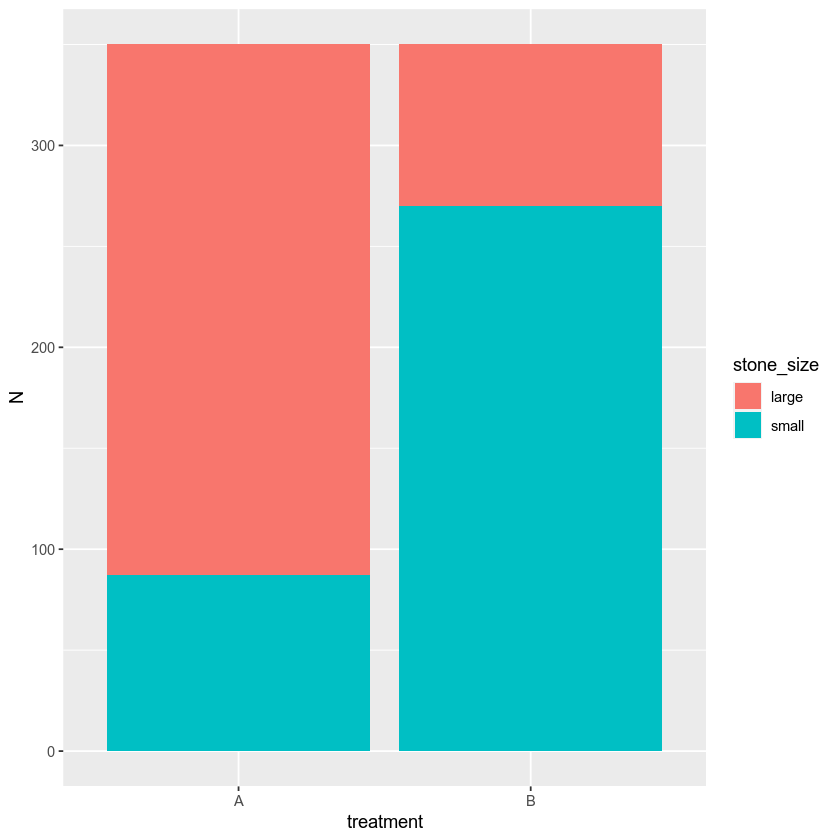

In [92]:
# Load ggplot2
library(ggplot2)

# Create a bar plot to show stone size count within each treatment
sum_data %>%
  ggplot(aes(x = treatment, y = N)) + 
  geom_bar(aes(fill = stone_size), stat = "identity") 

## 5. Identify and confirm the lurking variable
<p>From the bar plot, we noticed an unbalanced distribution of kidney stone sizes in the two treatment options. Large kidney stone cases tended to be in treatment A, while small kidney stone cases tended to be in treatment B. Can we confirm this hypothesis with statistical testing? </p>
<p>Let's analyze the association between stone size (i.e., case severity) and treatment assignment using a statistical test called <strong>Chi-squared</strong>. The <strong>Chi-squared</strong> test is appropriate to test associations between two categorical variables. This test result, together with the common knowledge that a more severe case would be more likely to fail regardless of treatment, will shed light on the root cause of the paradox.</p>

In [94]:
# Load the broom package 
library(broom)

# Run a Chi-squared test
trt_ss <- chisq.test(data$treatment, data$stone_size)  #used for two categorial variable relation; p value < 0.05 means these two are not related

# Print out the result in tidy format 
tidy(trt_ss)

statistic,p.value,parameter,method
<dbl>,<dbl>,<int>,<chr>
189.3557,4.395009e-43,1,Pearson's Chi-squared test with Yates' continuity correction


## 6. Remove the confounding effect
<p>After the above exercises, we are confident that stone size/case severity is indeed the lurking variable (aka, confounding variable) in this study of kidney stone treatment and success rate. The good news is that there are ways to get rid of the effect of the lurking variable. </p>
<p>Let's practice using multiple logistic regression to remove the unwanted effect of stone size, and then tidy the output with a function from the <code>broom</code> package.</p>

In [96]:
# Run a multiple logistic regression
m <- glm(data = data, success ~ stone_size + treatment, family = 'binomial')  #to set up a visual

# Print out model coefficient table in tidy format
tidy(m)

term	estimate	std.error	statistic	p.value
<chr>	<dbl>	<dbl>	<dbl>	<dbl>
(Intercept)	1.0332140	0.1344695	7.683629	1.546436e-14
stone_sizesmall	1.2605654	0.2390027	5.274272	1.332838e-07
treatmentB	-0.3572287	0.2290792	-1.559411	1.188991e-01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.0332140,0.1344695,7.683629,1.546436e-14
stone_sizesmall,1.2605654,0.2390027,5.274272,1.332838e-07
treatmentB,-0.3572287,0.2290792,-1.559411,1.188991e-01


## 7. Visualize model output
<p>We successfully fit a multiple logistic regression and pulled out the model coefficient estimates! Typically (and arbitrarily), P-values below 0.05 indicate statistical significance. Another way to examine whether a significant relationship exists or not is to look at the 95% confidence interval (CI) of the estimate. In our example, we are testing to see:</p>
<ol>
<li>if the effect of a small stone is the same as a big stone, and </li>
<li>if treatment A is as effective as treatment B. </li>
</ol>
<p>If the 95% CI for the coefficient estimates cover <strong>zero</strong>, we cannot conclude that one is different from the other. Otherwise, there is a significant effect. </p>

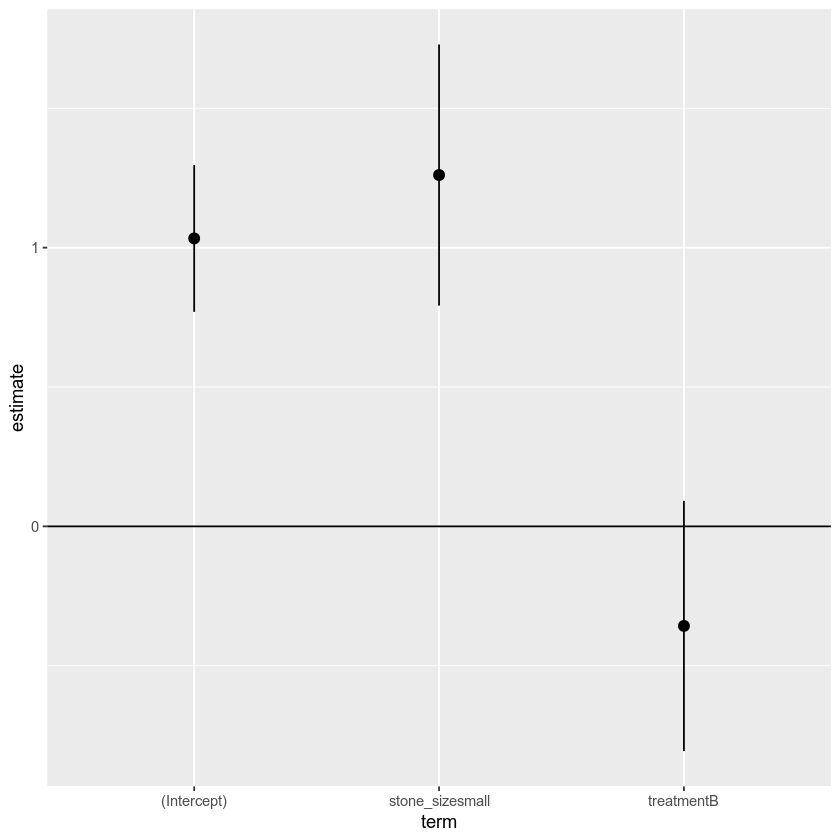

In [98]:
# Save the tidy model output into an object
tidy_m <- tidy(m)    #h0 is always defining: x is the same as y

# Plot the coefficient estimates with 95% CI for each term in the model
tidy_m %>%
  ggplot(aes(x=term, y=estimate)) + 
  geom_pointrange(aes(ymin=estimate-1.96*std.error, 
                      ymax=estimate+1.96*std.error)) +
  geom_hline(yintercept = 0)

## 8. Generate insights
<p>Based on the coefficient estimate plot and the model output table, there is enough information to generate insights about the study. Is treatment A superior to B after taking into account the effect of stone size/severity level?</p>
<p>Everything is in the output table from the regression model. Recall, a coefficient represents the effect size of the specific model term. A positive coefficient means that the term is positively related to the outcome. For categorical predictors, the coefficient is the effect on the outcome relative to the <code>reference category</code>. In our study, stone size large and treatment A are the reference categories.</p>

In [100]:
# Is small stone more likely to be a success after controlling for treatment option effect?  small is not the same as large, and small coefficient is >0, so higher success
# Options: Yes, No (as string)
small_high_success <- "Yes"

# Is treatment A significantly better than B?   A and B are the same
# Options: Yes, No (as string)
A_B_sig <- "No"